# Амангелді Нұралым СИБ 23-01, Зертханалық жұмыс 12

## Установка библиотек

In [2]:
# Импорт библиотеки NumPy и псевдонима np для удобства использования
import numpy as np

# Импорт библиотеки TensorFlow Datasets и псевдонима tfds
import tensorflow_datasets as tfds

# Импорт библиотеки TensorFlow и псевдонима tf
import tensorflow as tf

# Отключение строки прогресса при загрузке данных с использованием TensorFlow Datasets
tfds.disable_progress_bar()

2023-11-16 13:53:10.615881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 13:53:10.615930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 13:53:10.617515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Импорт библиотеки Matplotlib и псевдонима plt для удобства использования
import matplotlib.pyplot as plt

# Определение функции для построения графика метрики в ходе обучения
def plot_graphs(history, metric):
  # Построение графика для значения метрики на тренировочном наборе данных
  plt.plot(history.history[metric])
  
  # Построение графика для значения метрики на валидационном наборе данных
  plt.plot(history.history['val_'+metric], '')
  
  # Настройка осей графика
  plt.xlabel("Epochs")  # Метка по оси X - количество эпох (итераций обучения)
  plt.ylabel(metric)     # Метка по оси Y - значение выбранной метрики
  plt.legend([metric, 'val_'+metric])  # Добавление легенды для графиков

## Настройка входного конвейера

#### Далее, загрузили датасет с отзывами, разделили его на обучающую и тестовую выборки, и вывели информацию о структуре элементов обучающей выборки.

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

#### Следующий код берет первый элемент из обучающей выборки и выводит текст отзыва и соответствующую метку в удобном формате.

In [5]:
# Проходим через первый элемент обучающей выборки (take(1) означает взять один элемент)
for example, label in train_dataset.take(1):
    # Выводим текст отзыва, преобразованный в массив NumPy
    print('text: ', example.numpy())

    # Выводим метку отзыва, преобразованную в массив NumPy
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


#### Следующий код создает итераторы для обучающей и тестовой выборок, применяет перемешивание и упаковку данных, а затем выводит несколько текстов и соответствующих меток из первого пакета обучающей выборки. (text, label):

In [6]:
BUFFER_SIZE = 10000 # Определение размера буфера для перемешивания данных
BATCH_SIZE = 64     # Определение размера пакета для обучающей и тестовой выборок

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Перемешивание и упаковка данных для обучающей выборки
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Упаковка данных для тестовой выборки

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])  # Вывод трех меток отзывов из текущего пакета

texts:  [b'Watching beautiful women sneaking around, playing cops and robbers is one of the most delightful guilty pleasures the medium film lets me enjoy. So The House on Carroll Street was not entirely a waste of time, although the story is contrived and the screenplay uninspired and somewhat irritating.<br /><br />There are many allusions to different Hitchcock pictures, not least the choice of Kelly McGillis in the starring role. She is dressed up as Grace Kelly, and she is not far off the mark. Not at all. But her character is not convincing. The way she is introduced to the audience, she should be someone with political convictions and a purpose in life. After all the movie deals with a clearly defined time period, true events and a specific issue. But the story degenerates within the first minutes into a sorry run-off-the-mill crime story with unbelievable coincidences, high predictability and a set of two dimensional characters. This is all the more regrettable, as the performa

## Создание кодировщик текста

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE) # Создание слоя TextVectorization с максимальным количеством токенов равным VOCAB_SIZE
encoder.adapt(train_dataset.map(lambda text, label: text))

#### Этот код создает TextVectorization слой для кодирования текста с максимальным размером словаря, равным VOCAB_SIZE. Затем слой адаптируется к обучающей выборке, используя метод adapt, который строит словарь кодировщика на основе текстов из обучающей выборки.

In [10]:
vocab = np.array(encoder.get_vocabulary()) # Получение словаря (vocab) из кодировщика
vocab[:20] # Вывод первых 20 элементов словаря

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy() # Кодирование примеров текста с использованием ранее созданного TextVectorization слоя
encoded_example # Вывод закодированных текстов (первые три элемента из пакета)

array([[147, 300, 362, ...,   0,   0,   0],
       [  4, 579,   5, ...,   0,   0,   0],
       [  2, 348,  12, ...,   0,   0,   0]])

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Watching beautiful women sneaking around, playing cops and robbers is one of the most delightful guilty pleasures the medium film lets me enjoy. So The House on Carroll Street was not entirely a waste of time, although the story is contrived and the screenplay uninspired and somewhat irritating.<br /><br />There are many allusions to different Hitchcock pictures, not least the choice of Kelly McGillis in the starring role. She is dressed up as Grace Kelly, and she is not far off the mark. Not at all. But her character is not convincing. The way she is introduced to the audience, she should be someone with political convictions and a purpose in life. After all the movie deals with a clearly defined time period, true events and a specific issue. But the story degenerates within the first minutes into a sorry run-off-the-mill crime story with unbelievable coincidences, high predictability and a set of two dimensional characters. This is all the more regrettable, as the perfor

## Создание модели

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(     # Добавление слоя Embedding для преобразования числовых индексов в вектора
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Используйте маскировку для обработки переменных длин последовательностей
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

##### Эта модель принимает текстовые данные, кодирует их с использованием слоя TextVectorization (encoder), преобразует числовые индексы в вектора с помощью слоя Embedding, пропускает эти вектора через Bidirectional LSTM для обработки контекста в обе стороны последовательности, затем пропускает через полносвязный слой с функцией активации ReLU и, наконец, передает через выходной слой без функции активации для бинарной классификации.

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# Текстовый пример для предсказания
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Преобразование текста в массив и выполнение предсказания с использованием модели
predictions = model.predict(np.array([sample_text]))

# Вывод предсказания
print(predictions[0])

In [16]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 86ms/step
[0.00856275]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Обучение модели

In [18]:
# Обучение модели на обучающей выборке в течение 10 эпох
# Проверка эффективности на тестовой выборке после каждой эпохи
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


2023-11-16 13:53:32.243442: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'
I0000 00:00:1700142813.152065   83765 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 43s 88ms/step - loss: 0.6566 - accuracy: 0.5580 - val_loss: 0.5489 - val_accuracy: 0.7505
Epoch 2/10
391/391 [==============================] - 21s 54ms/step - loss: 0.4354 - accuracy: 0.7937 - val_loss: 0.3724 - val_accuracy: 0.8234
Epoch 3/10
391/391 [==============================] - 22s 54ms/step - loss: 0.3451 - accuracy: 0.8468 - val_loss: 0.3403 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 21s 52ms/step - loss: 0.3224 - accuracy: 0.8601 - val_loss: 0.3332 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 21s 52ms/step - loss: 0.3168 - accuracy: 0.8623 - val_loss: 0.3291 - val_accuracy: 0.8620
Epoch 6/10
391/391 [==============================] - 21s 52ms/step - loss: 0.3088 - accuracy: 0.8658 - val_loss: 0.3370 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 22s 52ms/step - loss: 0.3060 - accuracy: 0.8692 - val_loss: 0.3271 - val_accuracy: 0.8448
Epo

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 9s 23ms/step - loss: 0.3167 - accuracy: 0.8624
Test Loss: 0.3167201280593872
Test Accuracy: 0.8623600006103516


#### Следующий код создает график с двумя подграфиками (1 строка, 2 столбца). Первый подграфик отображает метрику точности (accuracy), а второй - метрику потерь (loss). В обоих случаях используется функция plot_graphs, которую, вероятно, вы реализовали для отображения соответствующих графиков. 

(0.0, 0.6744414046406746)

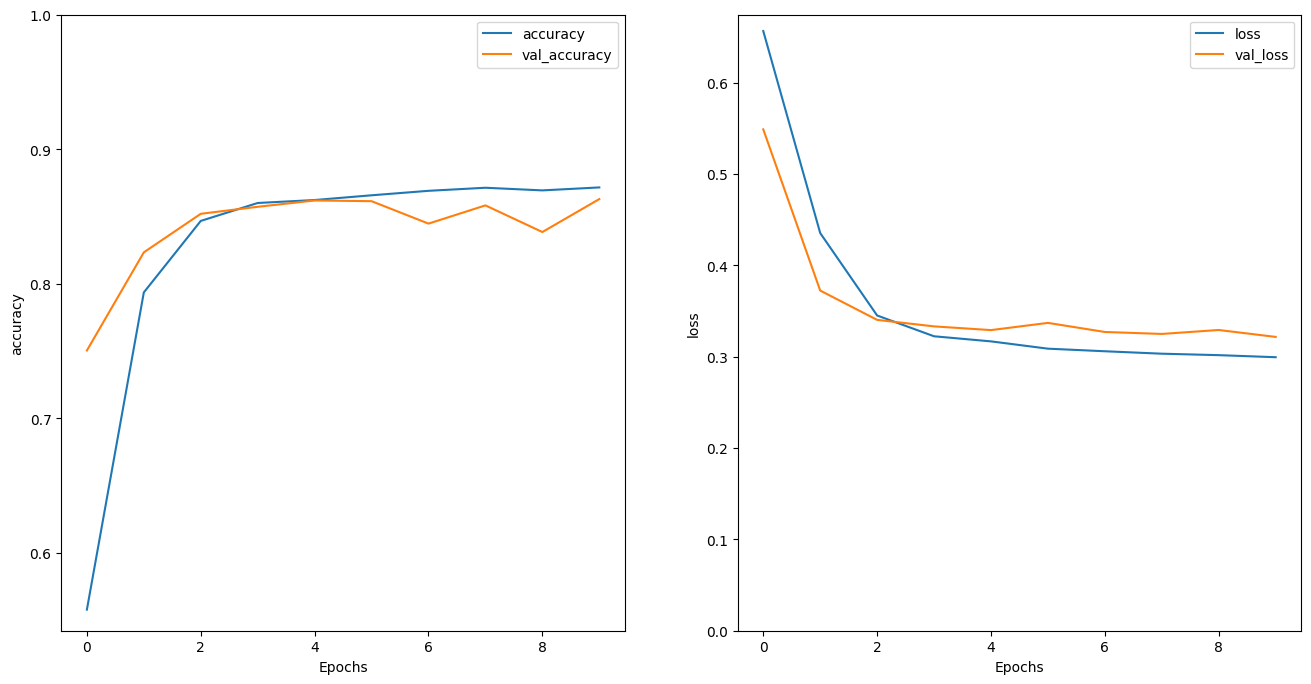

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Сложите два или более слоев LSTM

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True), # Добавление слоя Embedding для преобразования числовых индексов в вектора
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)), # Добавление двунаправленного LSTM слоя
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

### Эта модель имеет архитектуру, которая включает в себя слой Embedding для векторизации текста, два слоя LSTM (первый возвращающий последовательности, второй нет), полносвязный слой с функцией активации ReLU, слой Dropout для регуляризации, и выходной слой без функции активации для задачи бинарной классификации.

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10, # Обучение модели на обучающей выборке в течение 10 эпох
                    validation_data=test_dataset, # Проверка эффективности на тестовой выборке после каждой эпохи
                    validation_steps=30)   

Epoch 1/10
391/391 [==============================] - 66s 131ms/step - loss: 0.6284 - accuracy: 0.5935 - val_loss: 0.4341 - val_accuracy: 0.8031
Epoch 2/10
391/391 [==============================] - 40s 101ms/step - loss: 0.3818 - accuracy: 0.8336 - val_loss: 0.3429 - val_accuracy: 0.8474
Epoch 3/10
391/391 [==============================] - 40s 100ms/step - loss: 0.3369 - accuracy: 0.8557 - val_loss: 0.3489 - val_accuracy: 0.8458
Epoch 4/10
391/391 [==============================] - 40s 101ms/step - loss: 0.3265 - accuracy: 0.8590 - val_loss: 0.3239 - val_accuracy: 0.8589
Epoch 5/10
391/391 [==============================] - 39s 99ms/step - loss: 0.3123 - accuracy: 0.8678 - val_loss: 0.3265 - val_accuracy: 0.8500
Epoch 6/10
391/391 [==============================] - 40s 100ms/step - loss: 0.3072 - accuracy: 0.8690 - val_loss: 0.3242 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 40s 100ms/step - loss: 0.3060 - accuracy: 0.8673 - val_loss: 0.3211 - val_acc

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 17s 42ms/step - loss: 0.3255 - accuracy: 0.8652
Test Loss: 0.325457364320755
Test Accuracy: 0.8652399778366089


### Результаты оценки указывают на потери (loss) равные приблизительно 0.3255 и точность (accuracy) равную приблизительно 0.8652.

In [26]:
# мәтін үлгісі бойынша болжау

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-1.6299357]]


### Этот код создает график для отображения метрик обучения (точности и потерь)

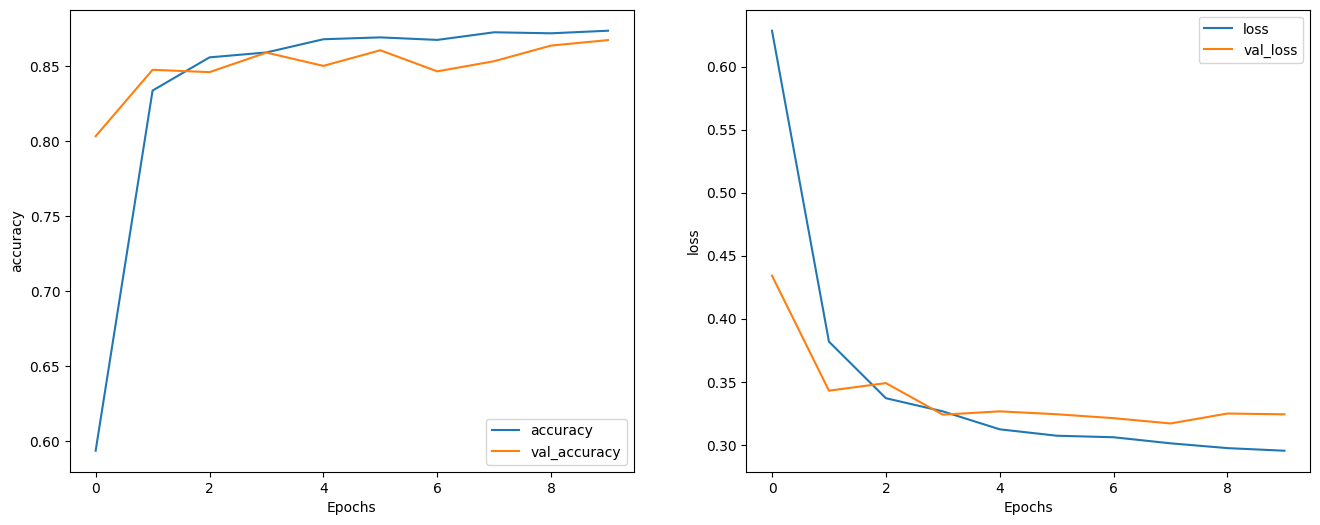

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')